# Отправка запросов в kserve

Изображение на сервер должно передоваться в формате ```base64```. 

Пример отправки запроса в kserve:

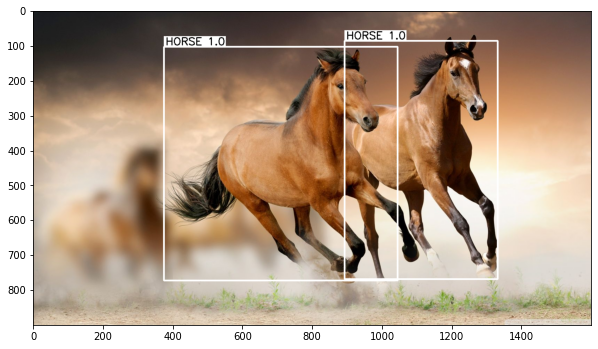

In [1]:
import base64
import json                    
import requests

import cv2
import bbox_visualizer as bbv
import matplotlib.pyplot as plt


def draw_outputs_on_image(image_path, outputs, threshold):
    outputs = outputs['predictions']
    threshold_outputs = {'bboxes':[], 'classes': [], 'scores':[]}
    for bbox, category, score in zip(outputs['pred_boxes'], outputs['pred_classes'], outputs['scores']):
        if score > threshold:
            threshold_outputs['bboxes'].append(bbox)
            threshold_outputs['classes'].append(category)
            threshold_outputs['scores'].append(score)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = [list(map(int, i)) for i in threshold_outputs['bboxes']]
    image_1 = bbv.draw_multiple_rectangles(image, bboxes)
    classes = [f"{label} {round(score, 1)}" for label, score in zip(threshold_outputs['classes'], threshold_outputs['scores'])]
    image_2 = bbv.add_multiple_labels(image_1, classes, bboxes)
    plt.figure(figsize=(10,10)); plt.imshow(image_2)
    
def infer(image_file):
    api = 'http://kserve:8080/v1/models/detectron:predict'
    with open(image_file, "rb") as f:
        im_bytes = f.read()        
    im_b64 = base64.b64encode(im_bytes).decode("utf8")
    headers = {'Content-type': 'application/json', 'Accept': '*/*'}
    payload = json.dumps({"image": im_b64})
    response = requests.post(api, data=payload, headers=headers)
    try:
        data = response.json()     
        return data                
    except requests.exceptions.RequestException:
        print(response.text)

        
image_file = '/app/dataset/test_imgs/horses.jpg'
outputs = infer(image_file)
draw_outputs_on_image(image_file, outputs, 0.7)